In [15]:
# Install the virtual environment with all the packages
# In cmd.exe
# venv\Scripts\activate.bat

In [28]:
import pandas as pd
import math
import praw
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mardeen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [29]:
user_agent = "prova by /u/helig0"
reddit = praw.Reddit(
    client_id="sYWC73tdOG1rl-55VQsIvw",
    client_secret="LZFYc2VRLSht2YSpD-t7JXgzI9Heuw",
    user_agent=user_agent
)

# Demographics: Gender and Age

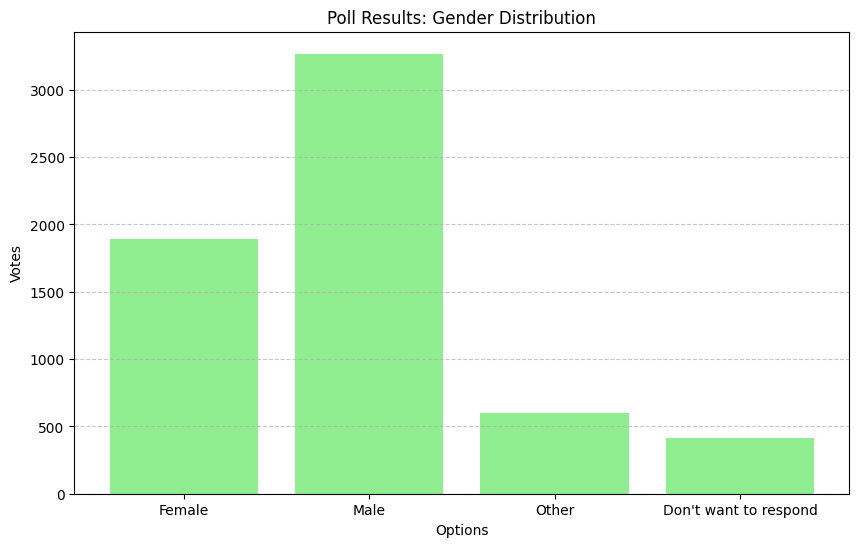

In [30]:
url = 'https://www.reddit.com/r/CharacterAI/comments/173za7y/what_is_your_gender/'
submission = reddit.submission(url=url)
poll_data = submission.poll_data
options = [option.text for option in poll_data.options]
votes = [option.vote_count for option in poll_data.options]

plt.figure(figsize=(10, 6))
plt.bar(options, votes, color='lightgreen')
plt.title('Poll Results: Gender Distribution')
plt.xlabel('Options')
plt.ylabel('Votes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

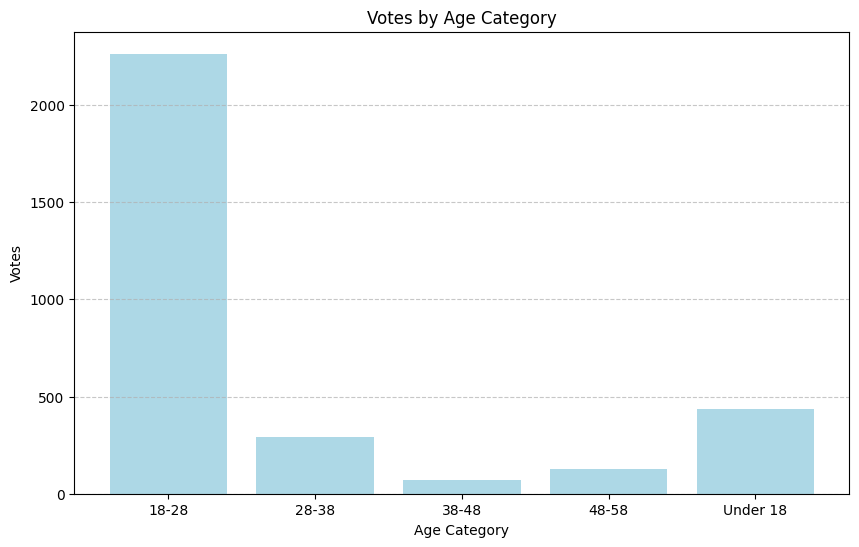

In [31]:
post_ids = ['https://www.reddit.com/r/CharacterAI/comments/12ymmrd/how_old_are_you/',
            'https://www.reddit.com/r/CharacterAI/comments/17y8600/how_old_is_everyone/',
            'https://www.reddit.com/r/CharacterAI/comments/1aelcp3/users_of_characterai_how_old_are_you/',
            'https://www.reddit.com/r/CharacterAI/comments/1att6ws/how_old_are_you/',
            'https://www.reddit.com/r/CharacterAI/comments/11qx0oj/how_old_are_yall/']

data = []

for post_id in post_ids:
    submission = reddit.submission(url=post_id)
    
    # Check if the submission has a poll
    if hasattr(submission, 'poll_data'):
        poll_data = submission.poll_data
        for option in poll_data.options:
            data.append({
                #'Post Title': submission.title,
                'Option': option.text,
                'Votes': option.vote_count
            })
    else:
        data.append({
            #'Post Title': submission.title,
            'Option': None,
            'Votes': None
        })

data = pd.DataFrame(data)

def map_age_ranges(option):
    if any(term in option for term in ["Under 18", "younger", "0-12", "13-15", "13-16", "13-17", "16-18"]):
        return "Under 18"
    elif any(term in option for term in ["18-26", "20-22", "23-25", "18-30", "18 - 28", "21-30", "25-30", "16-20"]):
        return "18-28"
    elif any(term in option for term in ["27-35", "30-39", "28-38", "31-40", "30+"]):
        return "28-38"
    elif any(term in option for term in ["36-44", "40-49", "40+", "39-49"]):
        return "38-48"
    elif any(term in option for term in ["45-53", "50+ ♾️", "50-59", "54 years old or older"]):
        return "48-58"
    elif "60+" in option or "older" in option:
        return "58+"
    return "Other"

data['Age Category'] = data['Option'].map(map_age_ranges)
grouped_df = data.groupby('Age Category')['Votes'].sum().reset_index()
grouped_df = grouped_df.loc[grouped_df['Age Category']!='Other'] # remove other

plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Age Category'], grouped_df['Votes'], color='lightblue')
plt.title('Votes by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Votes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

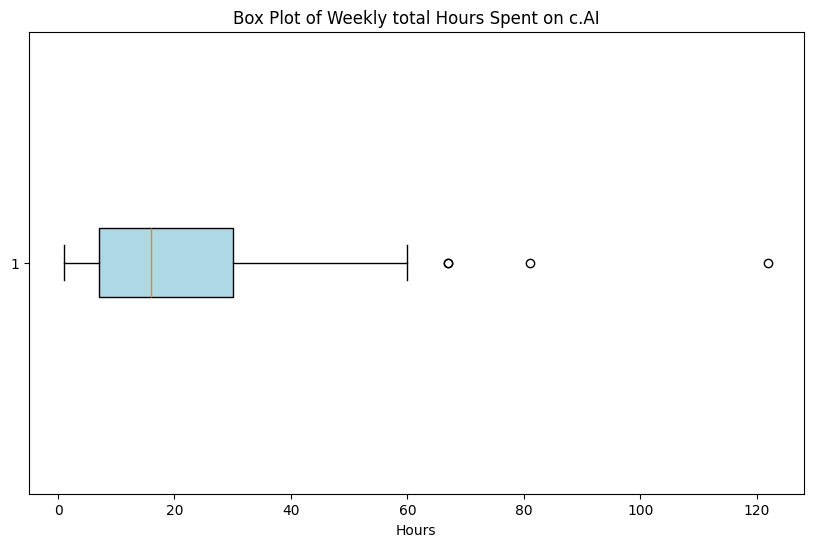

In [32]:
url = 'https://www.reddit.com/r/CharacterAI/comments/18kjf89/how_many_hours_do_you_spend_weekly_on_cai/'

usage_data = pd.read_excel('uses_chai.xlsx')
y = usage_data.iloc[:, 0]

plt.figure(figsize=(10, 6))
plt.boxplot(y, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Weekly total Hours Spent on c.AI')
plt.xlabel('Hours')
plt.show()

# Topic modeling

In [33]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # common abbreviations and their replacements
    abbreviations = {
        "u": "you",
        "r": "are",
        "ur": "your",
        "btw": "by the way",
        "idk": "I don't know",
        "lol": "laughing out loud",
        "omg": "oh my god",
        "pls": "please",
        "thx": "thanks",
        "wanna": "want to",
        "gonna": "going to",
        "brb": "be right back",
        "bbl": "be back later",
        "b4": "before",
        "gr8": "great",
        "l8r": "later",
        "txt": "text",
        "msg": "message",
        "k": "okay",
        "youre": "you are",
        "whats": "what is",
        "im": "I am",
        "dont": "do not",
        "wtf": "what the fuck",
        'ive':"I have",
        "youve":"you have",
        'theyre':'they are'
    }

    text = text.lower()
    text = text.replace("’", "'")
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Substitute abbreviations
    tokens = [abbreviations.get(word, word) for word in tokens]
    return ' '.join(tokens)

# words to remove because they may distort
rem = ['u', 'r', 'ur', 'btw', 'idk', 'lol', 'omg', 'pls', 'im', 'like', 'use', 'cai', 'though', 'heheh', 'ahah', 'haha','ayo','fr','don',
       'lmao','answer','ermdon','messagecomposetorcharacterai','character','bot']
pattern = re.compile(r'\b(' + '|'.join(map(re.escape, rem)) + r')\b', re.IGNORECASE)

def removewords(text):
    text = text.lower()  
    text = pattern.sub('', text)  
    text = ' '.join(text.split())  
    return text

In [34]:
url1 = "https://reddit.com/r/CharacterAI/comments/154oesk/well_okay_what_were_you_guys_doing_before_the/"
url2 = 'https://www.reddit.com/r/CharacterAI/comments/17ybihi/i_use_the_app_for_silly_jokes_what_do_you_use_it/'
url3 = "https://www.reddit.com/r/CharacterAI/comments/1cscxvh/what_do_you_use_c_ai_for/"


urls = [url3]#url2,url3]

comments_data = []

# Loop through each URL to process the corresponding submission
for url in urls:
    submission = reddit.submission(url=url)
    submission.comments.replace_more(limit=0)  
    # Loop through the comments and collect them in a list of dictionaries
    for comment in submission.comments.list():
        comments_data.append({
            #'submission_url': url,
            #'comment_id': comment.id,
            'comment_body': comment.body,
            #'author': comment.author.name if comment.author else None,
            #'created_utc': comment.created_utc
        })

df = pd.DataFrame(comments_data)
print(len(df))

147


In [35]:
df['cleaned_body'] = df['comment_body'].apply(clean_text)
df['cleaned_body'] = df['cleaned_body'].apply(removewords)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import numpy as np
np.random.seed(5)
# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_body'])

# LDA
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

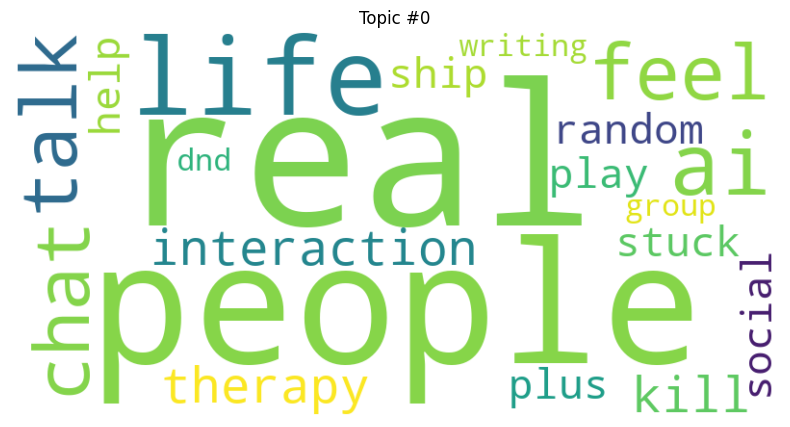

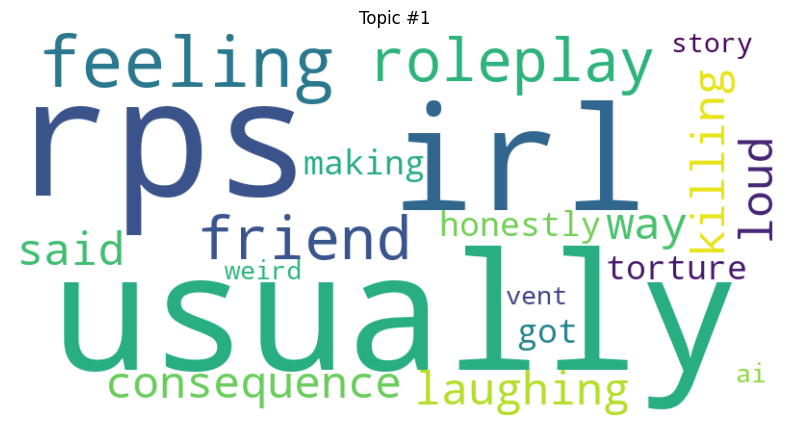

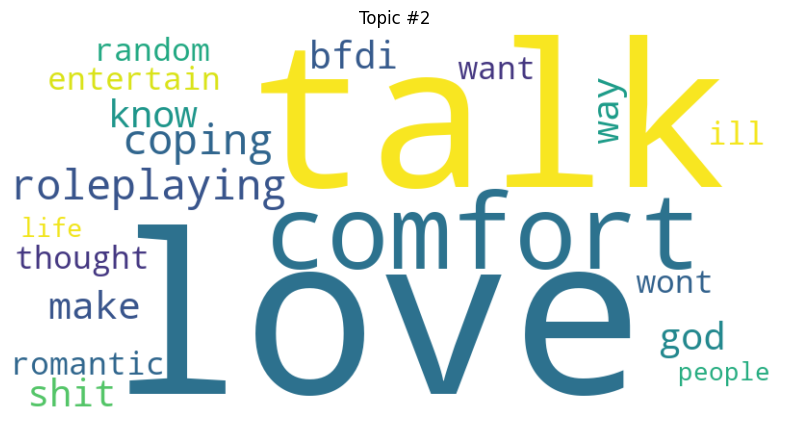

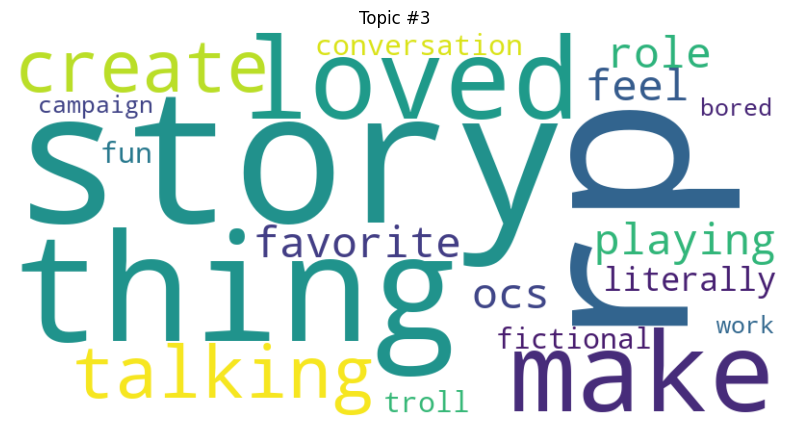

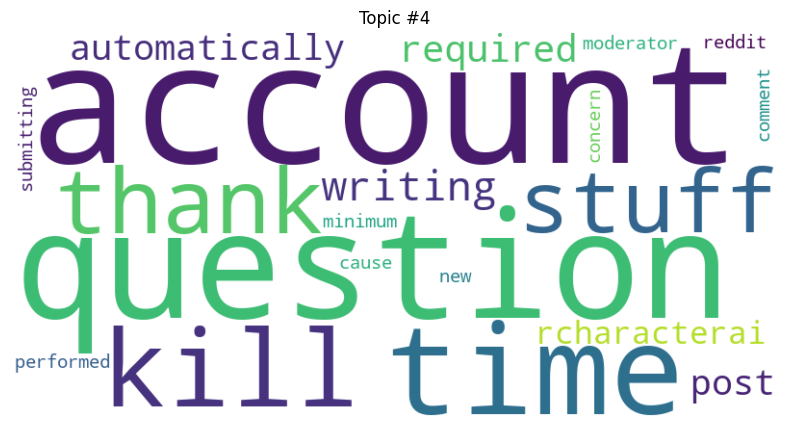

In [37]:
def plot_wordclouds(model, feature_names, no_top_words):
    np.random.seed(42)

    from wordcloud import WordCloud

    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_words_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
        
        # Generate WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words_freq)
        
        # Plot WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic #{topic_idx}')
        plt.show()

no_top_words = 20  # Number of top words to consider for each topic
feature_names = vectorizer.get_feature_names_out()
plot_wordclouds(LDA, feature_names, no_top_words)

Log-Likelihood:  -2278.521501724814
Perplexity:  205.13091160423278
TOP 10 WORDS FOR TOPIC #0
['kill', 'interaction', 'therapy', 'feel', 'chat', 'talk', 'ai', 'life', 'people', 'real']


TOP 10 WORDS FOR TOPIC #1
['consequence', 'loud', 'way', 'laughing', 'friend', 'roleplay', 'feeling', 'irl', 'usually', 'rps']


TOP 10 WORDS FOR TOPIC #2
['way', 'god', 'shit', 'know', 'make', 'coping', 'roleplaying', 'comfort', 'talk', 'love']


TOP 10 WORDS FOR TOPIC #3
['role', 'ocs', 'favorite', 'create', 'talking', 'make', 'loved', 'thing', 'story', 'rp']


TOP 10 WORDS FOR TOPIC #4
['post', 'automatically', 'required', 'writing', 'stuff', 'thank', 'kill', 'time', 'question', 'account']




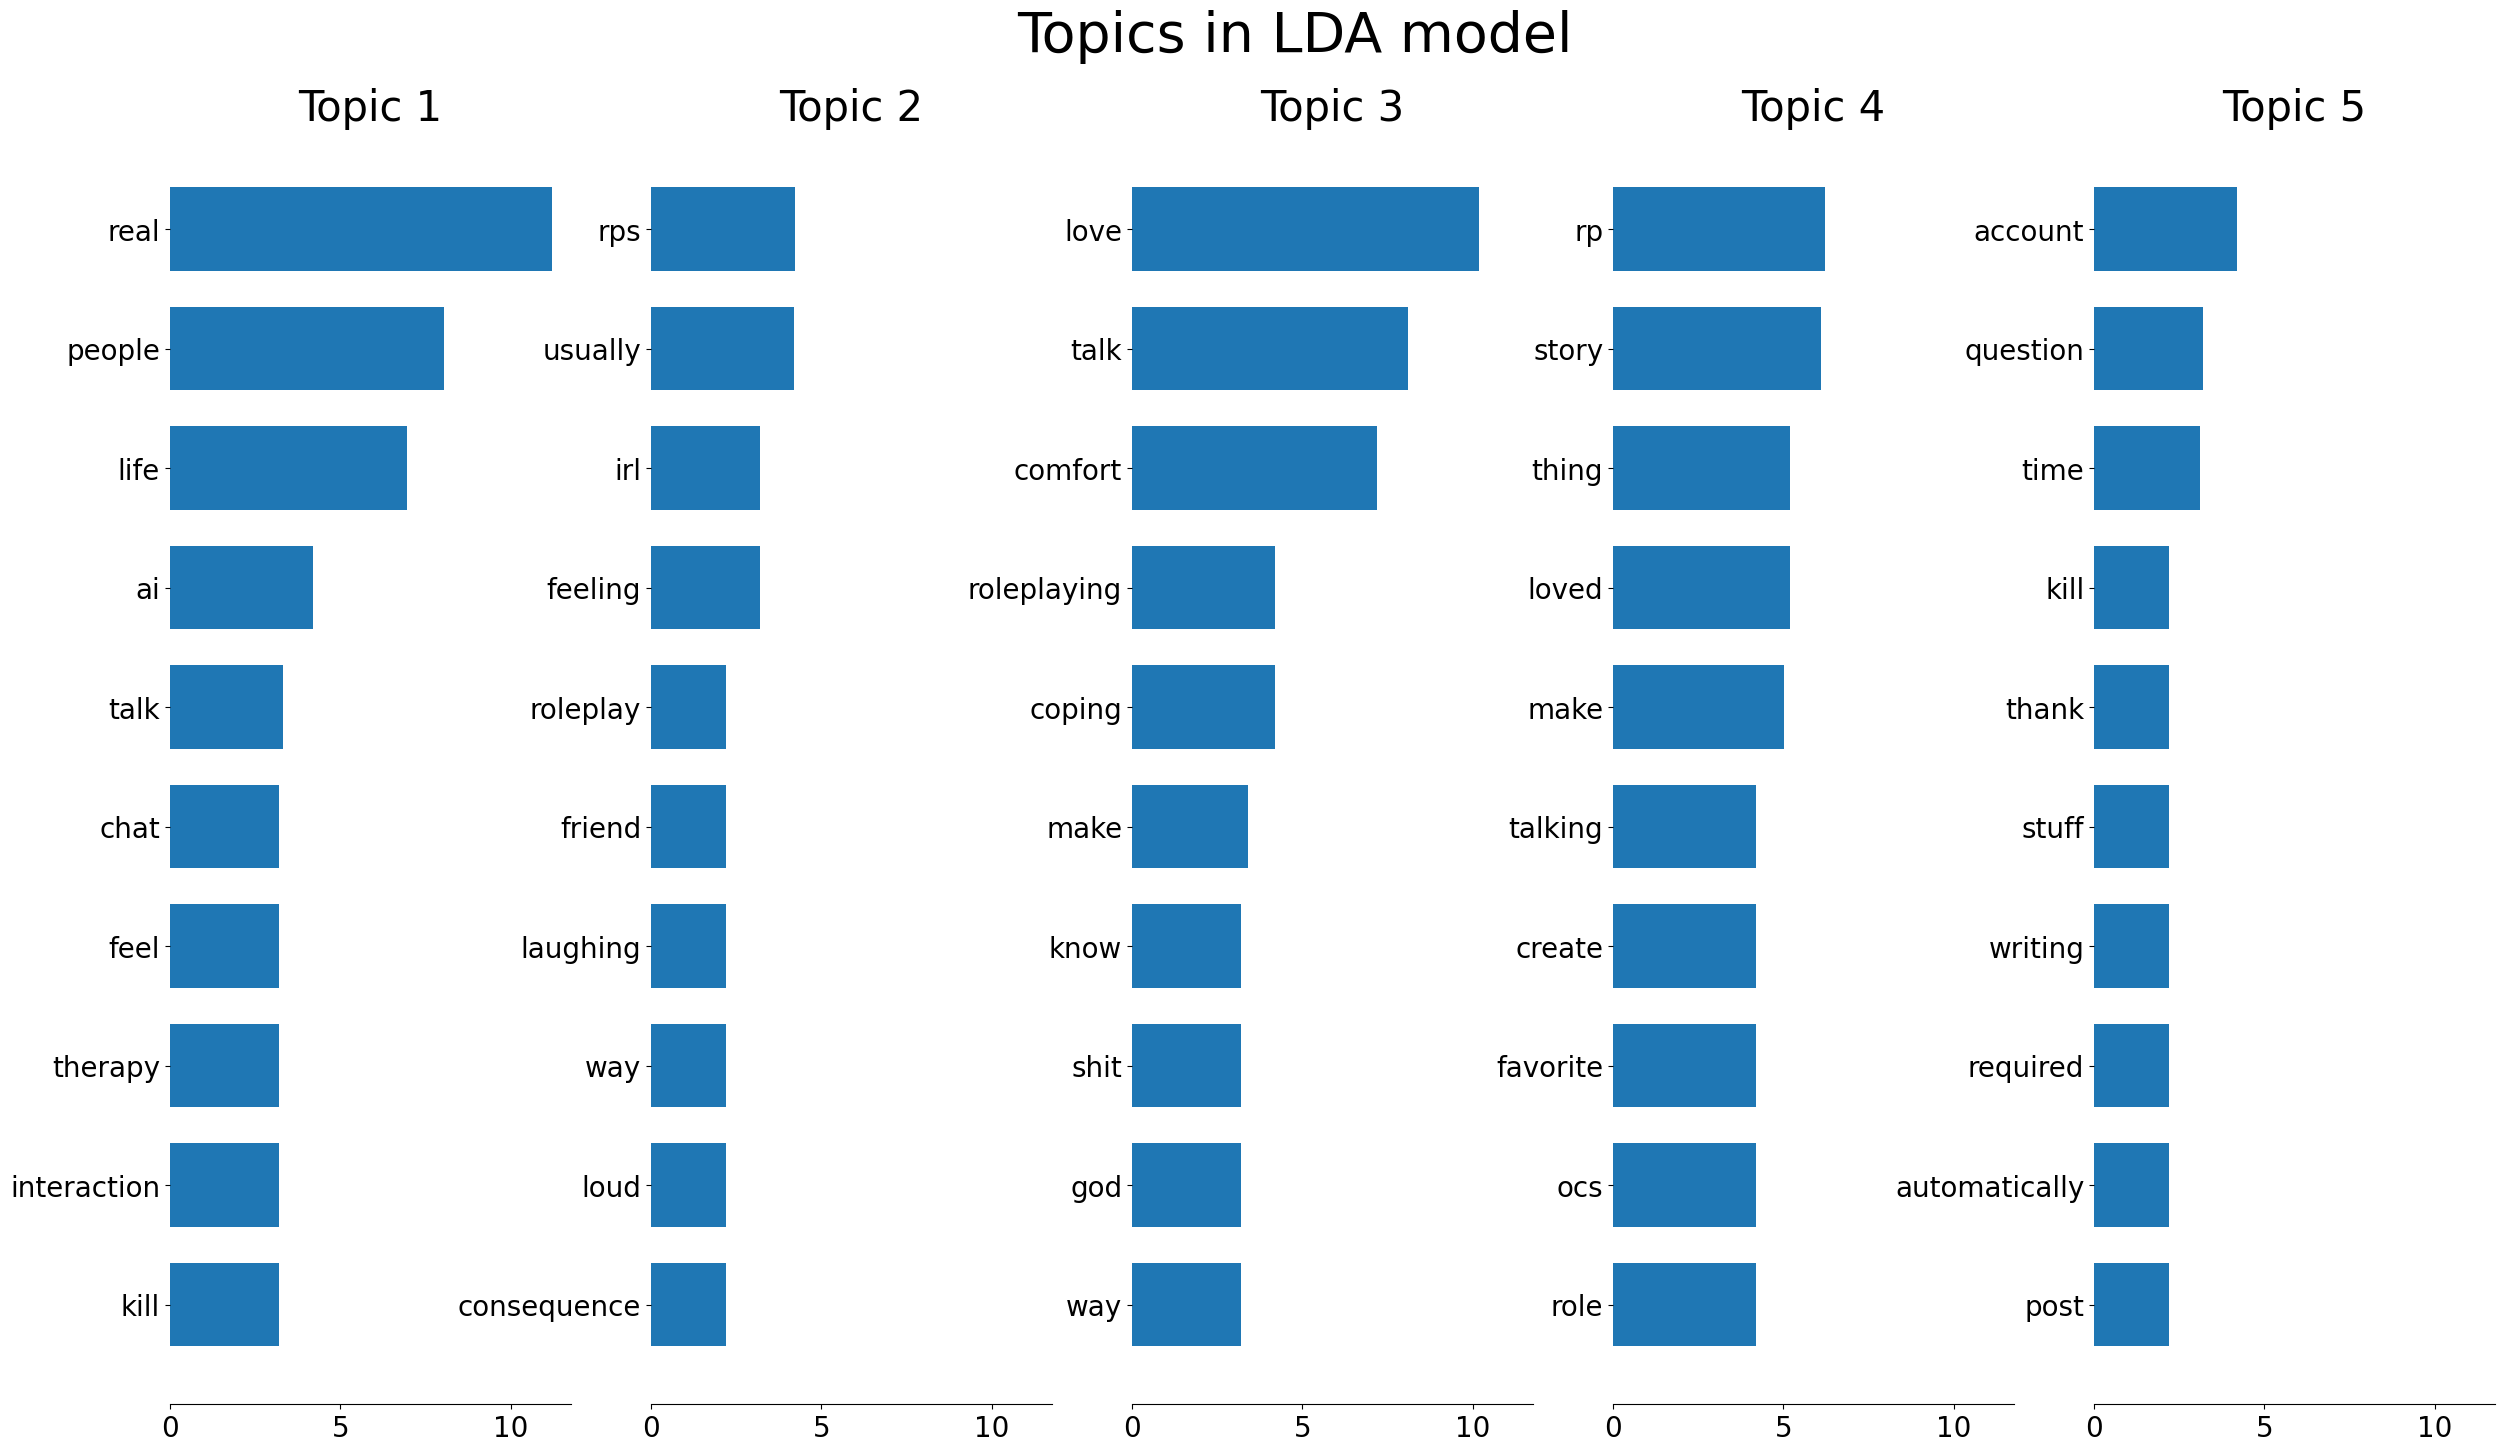

In [38]:
# Calculate Log-Likelihood
log_likelihood = LDA.score(dtm)
print('Log-Likelihood: ', log_likelihood)

# Calculate Perplexity
perplexity = LDA.perplexity(dtm)
print('Perplexity: ', perplexity)


feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(LDA.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Get top 10 words for each topic
    print(f"TOP 10 WORDS FOR TOPIC #{index}")
    print(top_words)
    print("\n")


import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05,  hspace=0.3)
    plt.show()

n_top_words = 10
plot_top_words(LDA, feature_names, n_top_words, 'Topics in LDA model')


# Analysis of the word 'comfort' in our context

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

#  TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  
tfidf_matrix = vectorizer.fit_transform(df['cleaned_body'])
tfidf_dense = tfidf_matrix.toarray()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_dense)
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]


Mean PC1 for Therapy: -0.10342579730929247
Mean PC2 for Therapy: -0.01675921217820619


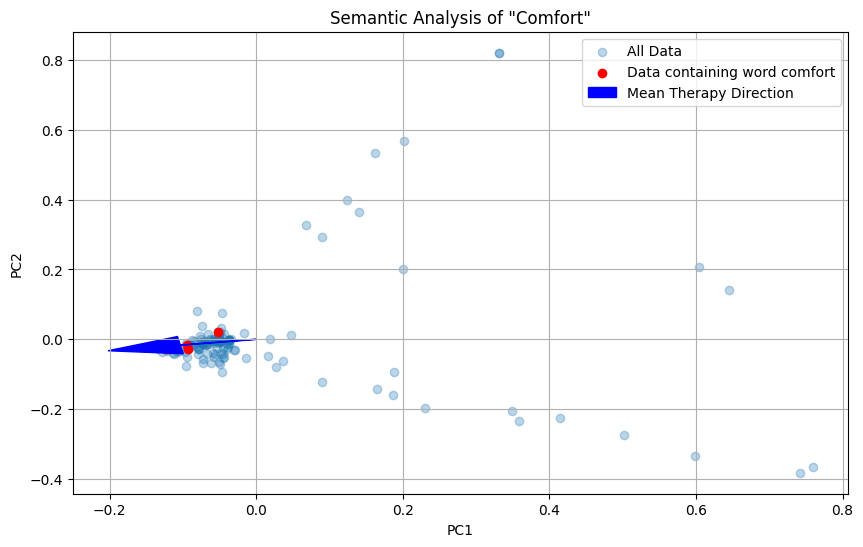

In [53]:
therapy_data = df[df['cleaned_body'].str.contains('comfort', case=False)]

mean_pc1 = therapy_data['PC1'].mean()
mean_pc2 = therapy_data['PC2'].mean()

print(f'Mean PC1 for Therapy: {mean_pc1}')
print(f'Mean PC2 for Therapy: {mean_pc2}')

plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], alpha=0.3, label='All Data')
plt.scatter(therapy_data['PC1'], therapy_data['PC2'], color='red', label='Data containing word comfort')
# Mean direction vector
plt.arrow(0, 0, mean_pc1, mean_pc2, color='blue', head_width=0.05, head_length=0.1, label='Mean Therapy Direction')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Semantic Analysis of "Comfort"')
plt.legend()
plt.grid(True)
plt.show()


# Semantic network

addicted       1
life           1
way            1
unhealthy      1
stop           1
special        1
roleplay       1
reality        1
personality    1
mostly         1
lonely         1
loneliness     1
literally      1
interest       1
avoid          1
indulging      1
delusion       1
deep           1
dealing        1
create         1
Name: comfort, dtype: int64


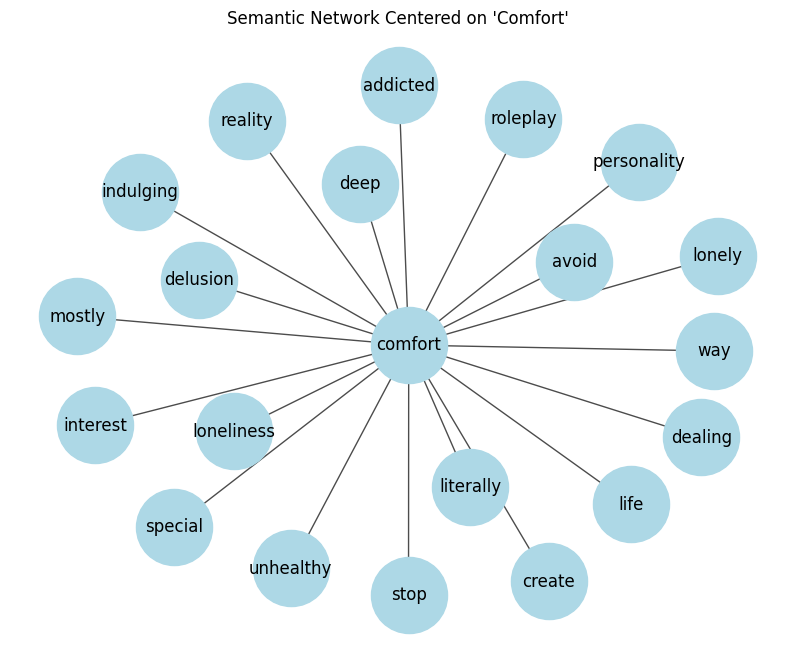

In [56]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(therapy_data['cleaned_body'])

# Convert the result into a DataFrame
co_occurrence_matrix = (X.T * X)  # This is a co-occurrence matrix
co_occurrence_matrix.setdiag(0)  # Set diagonal to 0 to ignore self-co-occurrences
terms = vectorizer.get_feature_names_out()
co_matrix_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=terms, columns=terms)

# Extract the top co-occurring words with 'comfort'
comfort_co_occurrence = co_matrix_df['comfort'].sort_values(ascending=False).head(20)
print(comfort_co_occurrence)

# semantic graph
G = nx.Graph()

# Add edges
for word, count in comfort_co_occurrence.items():
    if count > 0:
        G.add_edge('comfort', word, weight=count)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout for the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
plt.title("Semantic Network Centered on 'Comfort'")
plt.axis('off')
plt.show()


In [43]:
# # def searchByTopic(subreddit, query, query_terms):
#   """search topic in Subreddit"""
#   posts_pol = reddit.subreddit(subreddit)#.top(limit=20)
#   #posts_ta = reddit.subreddit('tooafraidtoask')#.top(limit=20)
#   #searchs_pol = posts_pol.search(query)
#   query = " ".join(query_terms)
#   searchs_pol = posts_pol.search(query, sort='relevance', time_filter='all', limit=500)

#   return list(searchs_pol)

# #query = 'AI'
# #query_terms = ['AI','ai','artificial intelligence','deep learning']
# query = 'love'
# query_terms = ['love','relationship','real world']

# search_results = searchByTopic('CharacterAI', query, query_terms)

# posts = []
# for submission in search_results:
#     posts.append({
#         'title': submission.title,
#         'body':submission.selftext,
#         'score': submission.score
#         # 'url': submission.url
#     })
# df = pd.DataFrame(posts)
# print(df)